# Outlier Detection

In [1]:
# We will be using the following libs
# Data
import numpy as np 
import pandas as pd 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

## Univariate

### Parametric methods

First, let's create a dataframe with dummy data where features have **normal distributions** in order to explore  univariate parametric methods for outlier detection.

In [2]:
# Random Seed
np.random.seed(1)
features_number = 4
dummy_df = pd.DataFrame(np.random.normal(scale=10.0, size=(1000, features_number)),
                        columns=['feature{}'.format(i) for i in range(features_number)])
dummy_df

,feature0,feature1,feature2,feature3
0,16.243454,-6.117564,-5.281718,-10.729686
1,8.654076,-23.015387,17.448118,-7.612069
2,3.190391,-2.493704,14.621079,-20.601407
3,-3.224172,-3.840544,11.337694,-10.998913
4,-1.724282,-8.778584,0.422137,5.828152
...,...,...,...,...
995,-1.388814,26.521397,-6.562470,2.795620
996,-6.077151,7.298136,-8.871875,0.773272
997,0.734163,4.160262,-18.792000,5.754588
998,1.020624,11.843037,-7.948430,-1.259031


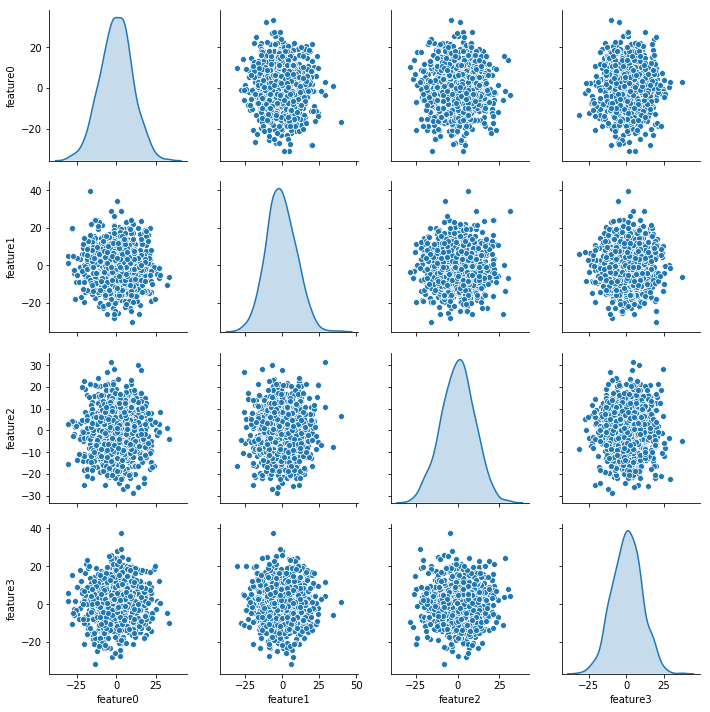

In [3]:
# Notice data is normally distributed
sns.pairplot(dummy_df, diag_kind="kde")

In [4]:
# Data has enough variation between features to have some outliers
dummy_df.describe()

,feature0,feature1,feature2,feature3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.130295,-0.467723,0.163857,0.649251
std,10.144231,9.967537,9.940642,9.869792
min,-30.641414,-30.160320,-28.720503,-31.533575
25%,-6.542388,-7.276946,-6.570169,-6.132045
50%,0.225131,-0.939612,0.371522,0.828764
75%,6.670833,6.081050,6.728782,7.298686
max,33.210788,39.586027,31.350473,37.402489


One way to detect outliers is by computing the mean and __standard deviation__ in data. Then, we can mark as outliers all the observations which are more than *nstd* deviations units away from the mean: 

In [5]:
# Compute mean and sdt
feature = 'feature0'
data_mean, data_std = dummy_df[feature].mean(), dummy_df[feature].std()
print("feature0 mean:{} std:{}".format(data_mean, data_std))

feature0 mean:0.13029500275266503 std:10.144231491155765


In [6]:
# Distance from mean
nstd = 3.0
dist = data_std * nstd

# Bounds
lower_bound, upper_bound = data_mean - dist, data_mean + dist
print('[',lower_bound,',',upper_bound,']')

[ -30.30239947071463 , 30.562989476219958 ]


In [7]:
# Outliers mask, True = Outlier
outliers_mask = [True if x < lower_bound or x > upper_bound else False for x in dummy_df[feature]]
print("Outliers:\n{}".format(dummy_df[feature][outliers_mask]) )

Outliers:
183    33.210788
223   -30.537644
567   -30.641414
762    32.383432
Name: feature0, dtype: float64


We can also visualize outliers in the distribution [histogram](https://seaborn.pydata.org/generated/seaborn.distplot.html):

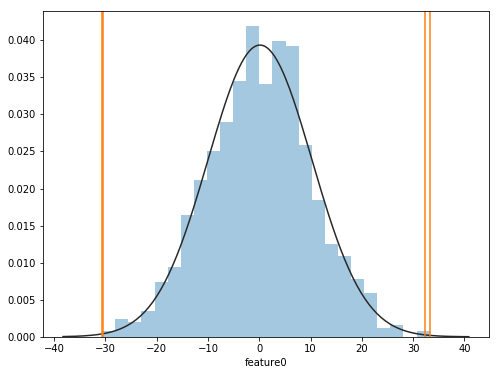

In [8]:
# Normal fitting for reference curve
from scipy.stats import norm

# Plot the distribution histogram and highlight outliers in red
plt.figure(figsize=(8,6))
sns.distplot(dummy_df[feature], fit=norm ,kde=False);
for outlier in dummy_df[feature][outliers_mask]:
    plt.axvline(outlier, 0, dummy_df[feature].max(), color = '#FF7F0E')

An altertative method is to detect outliers computing the *Q25-Q75* __interquartile range (IR)__. Then, we can mark as outliers all the observations which are more than $k*IR$ units away from the *Q25* and *Q75*: 

In [9]:
# Compute interquartile range
q25, q75 = np.percentile(dummy_df[feature], 25), np.percentile(dummy_df[feature], 75)
iqr = q75 - q25
iqr

13.213220892526852

In [10]:
# Compute the outlier range
k = 1.5
range_ir = iqr * k

# Bounds
lower_bound_ir, upper_bound_ir = q25 - range_ir, q75 + range_ir

In [11]:
# Outliers mask, True = Outlier
outliers_mask_ir = [True if x < lower_bound_ir or x > upper_bound_ir else False for x in dummy_df[feature]]
print("Outliers:\n{}".format(dummy_df[feature][outliers_mask_ir]) )

Outliers:
63    -27.930850
183    33.210788
223   -30.537644
244   -26.641259
427   -27.914440
567   -30.641414
684    27.294621
762    32.383432
771   -26.768414
783   -27.391417
969    27.061249
976    27.421552
Name: feature0, dtype: float64


Let's now visualize the outliers in the distribution [histogram](https://seaborn.pydata.org/generated/seaborn.distplot.html) and corresponding [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html):

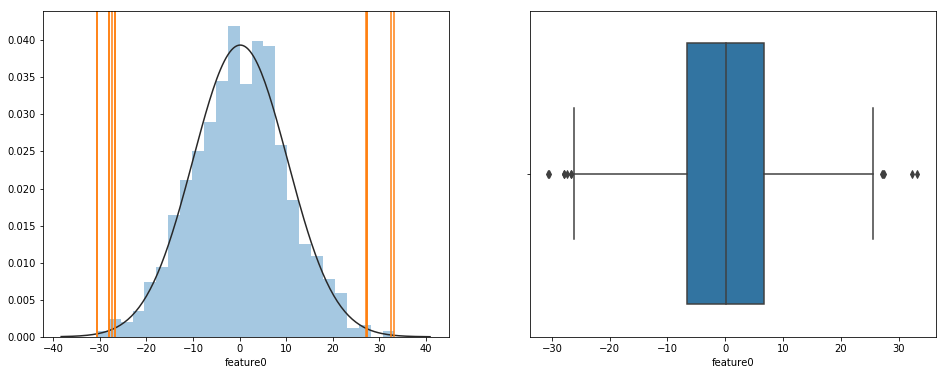

In [12]:
# Plot the distribution histogram and highlight outliers in red
plt.figure(figsize=(16,6))
ax1=plt.subplot(1, 2, 1)

sns.distplot(dummy_df[feature], fit=norm ,kde=False, ax = ax1);
for outlier in dummy_df[feature][outliers_mask_ir]:
    plt.axvline(outlier, 0, dummy_df[feature].max(), color = '#FF7F0E')
    
ax2=plt.subplot(1, 2, 2)
sns.boxplot(x=dummy_df[feature], whis=k, ax = ax2)

### Non-parametric methods

To explore non-parametric methods we are going to use the [Melbourne Housing dataset](https://www.kaggle.com/anthonypino/melbourne-housing-market):

In [13]:
df_housing = pd.read_csv('https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/4_DataWrangling/data/Melbourne_housing_FULL.csv')
df_housing.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


Let's fill missing values with the median value in each column. We use [`pandas.DataFrame.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html).

In [14]:
df_housing.fillna(df_housing.median(), inplace=True)

Plot data distribution:

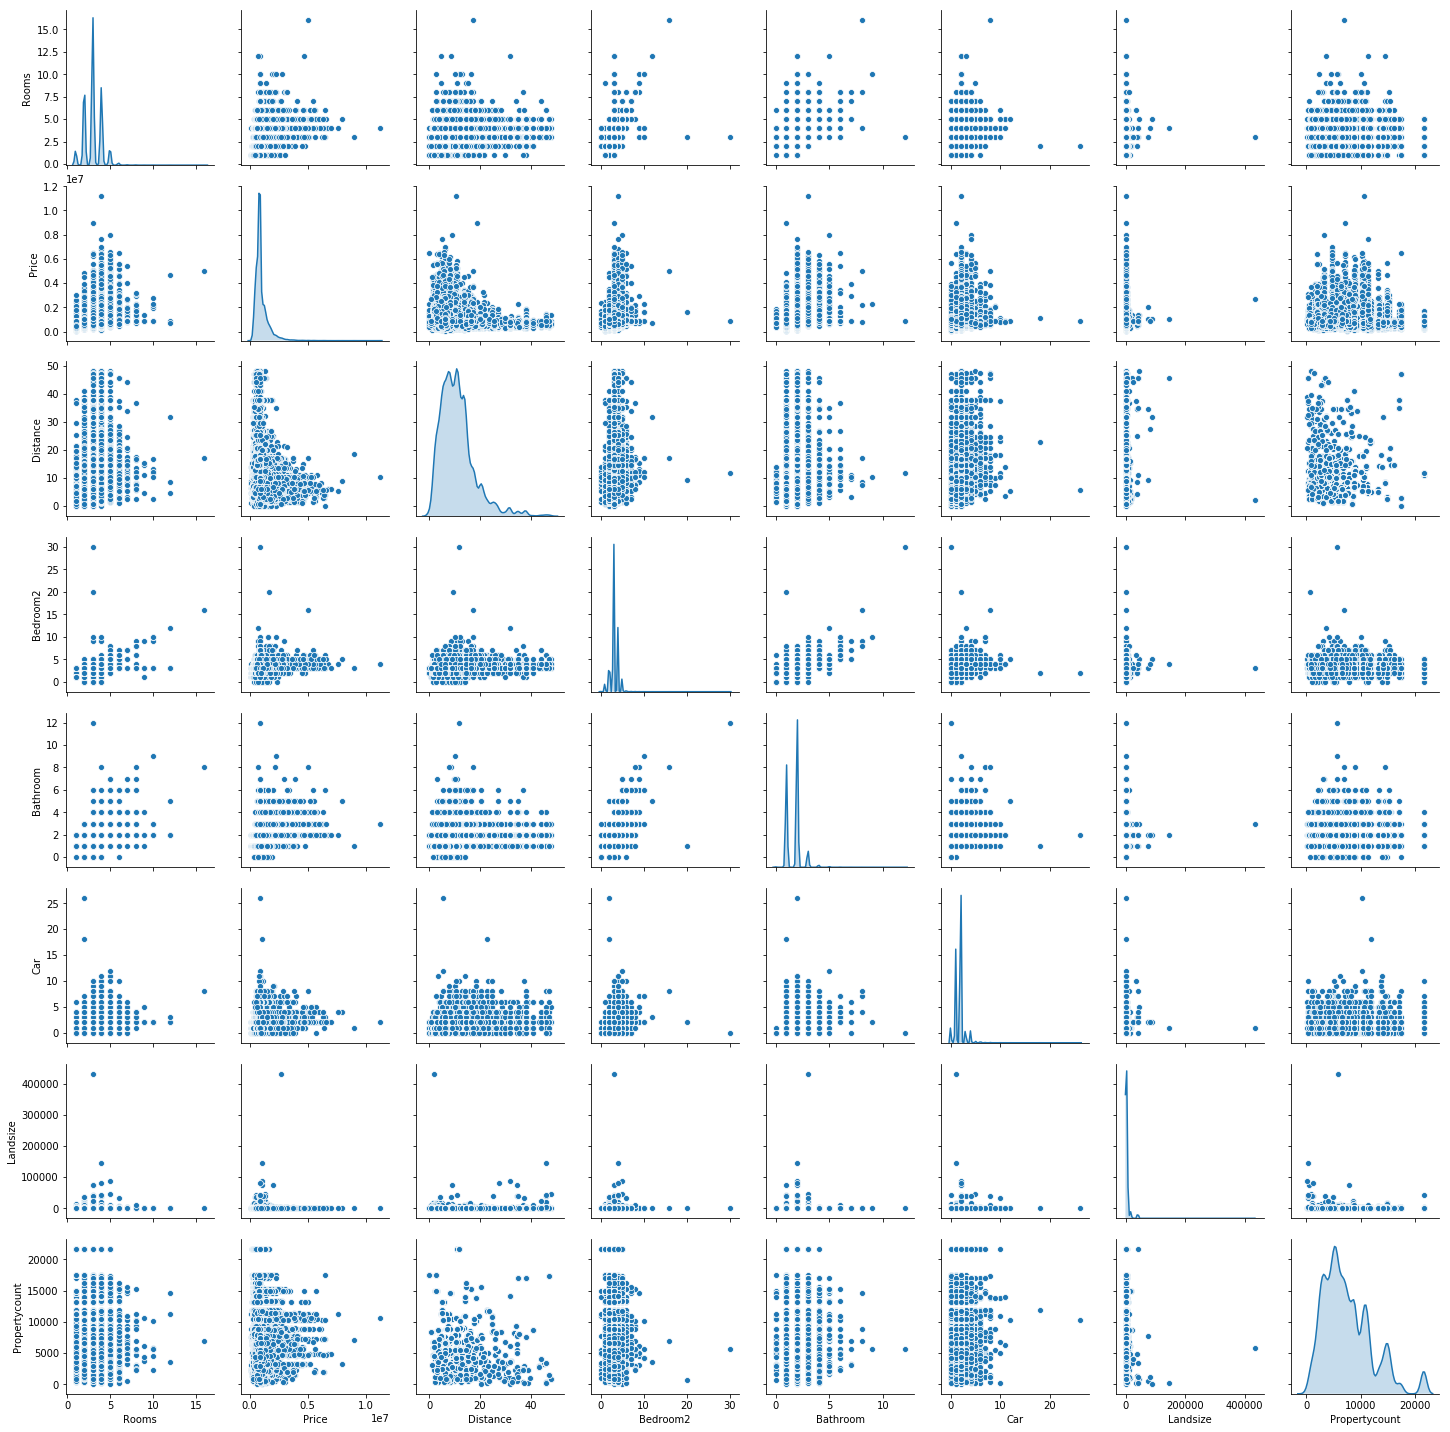

In [15]:
cols = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']
sns.pairplot(df_housing[cols], diag_kind="kde")

The [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The number of splittings required to isolate a sample is noticeably lower for anomalies. The Scikit-learn implementation of this algorithm returns an anomaly score of each sample:

In [16]:
from sklearn.ensemble import IsolationForest

# Outliers in Rooms column
column = 'Rooms'

# Fit 
isolation_forest = IsolationForest(contamination='auto',random_state=0)
isolation_forest.fit(df_housing[column].values.reshape(-1,1))

IsolationForest(random_state=0)

Once fitted, we can predict the anomaly score for data in the column, or even new values.

In [17]:
# New samples in the Rooms value range
xx            = np.linspace(df_housing[column].min(), df_housing[column].max(), len(df_housing)).reshape(-1,1)

# Predict the anomaly_score using isolation forest
anomaly_score = isolation_forest.decision_function(xx)
outlier       = isolation_forest.predict(xx)

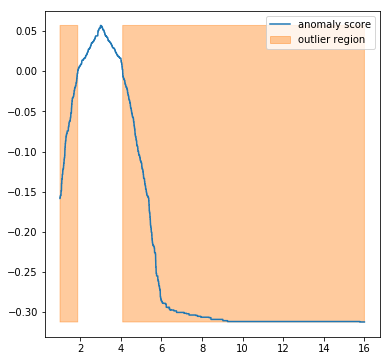

In [18]:
# Outliers plot
plt.figure(figsize=(6,6))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='#FF7F0E', 
                 alpha=.4, label='outlier region')
plt.legend()

Notice the Isolation Forest marks as an outlier any house with less than 2 rooms and more than 4. 

## Multivariate

### Parametric methods

In the multivariate context, parametric methods as the [Elliptic Envelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) can be used to detect and remove outliers in a Gaussian distributed dataset. Let's go back to our `dummy_df` and remove outliers by looking at multiple columns simultaneously: 

In [19]:
dummy_df

,feature0,feature1,feature2,feature3
0,16.243454,-6.117564,-5.281718,-10.729686
1,8.654076,-23.015387,17.448118,-7.612069
2,3.190391,-2.493704,14.621079,-20.601407
3,-3.224172,-3.840544,11.337694,-10.998913
4,-1.724282,-8.778584,0.422137,5.828152
...,...,...,...,...
995,-1.388814,26.521397,-6.562470,2.795620
996,-6.077151,7.298136,-8.871875,0.773272
997,0.734163,4.160262,-18.792000,5.754588
998,1.020624,11.843037,-7.948430,-1.259031


In [20]:
# Import Elliptic Envelope
from sklearn.covariance import EllipticEnvelope

# Fit the first two features in dummy_df
clf = EllipticEnvelope()
clf.fit(dummy_df.values[:,:2])

EllipticEnvelope()

Plot the fitted elliptic envelope. Anything outside the dashed line is considered an outlier.

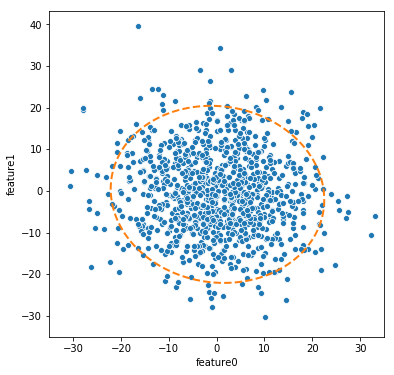

In [21]:
# Plotting the ellipse 
xx, yy = np.meshgrid(np.linspace(-35, 35, 500), np.linspace(-35, 35, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6,6))
sns.scatterplot(x="feature0", y="feature1", data=dummy_df)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='#FF7F0E', linestyles='dashed')

Notice we fitted an elliptic envelope to bidimensional data in order to be able to easily visualize it. However, you could use it to fit data with more than two dimensions. 

### Non-parametric methods

Clustering algorithms can often be used to detect otuliers. Such is the case of the Density-based spatial clustering of applications with noise __(DBSCAN)__ implemented in [`sklearn.cluster.DBSCAN()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). It is a very quick, nonparametric method that can be used in multivariate analyses. Output clusters will be significantly affected by `eps` and `min_samples`. Let's follow an example using our housing data.

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# When working with clustering problems, scale data it is crucial
df_housing_scaled = StandardScaler().fit_transform(df_housing[cols].values)

# Fit
db = DBSCAN(eps=3.0, min_samples=10).fit(df_housing_scaled)
labels = db.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
# Count the number of outliers from the sample labels (=-1) 
pd.Series(labels).value_counts() 

 0    34797
-1       60
dtype: int64

Let's visualize outliers. Notice we are inspecting pair-wise relationships between *price* and other dataset dimensions:

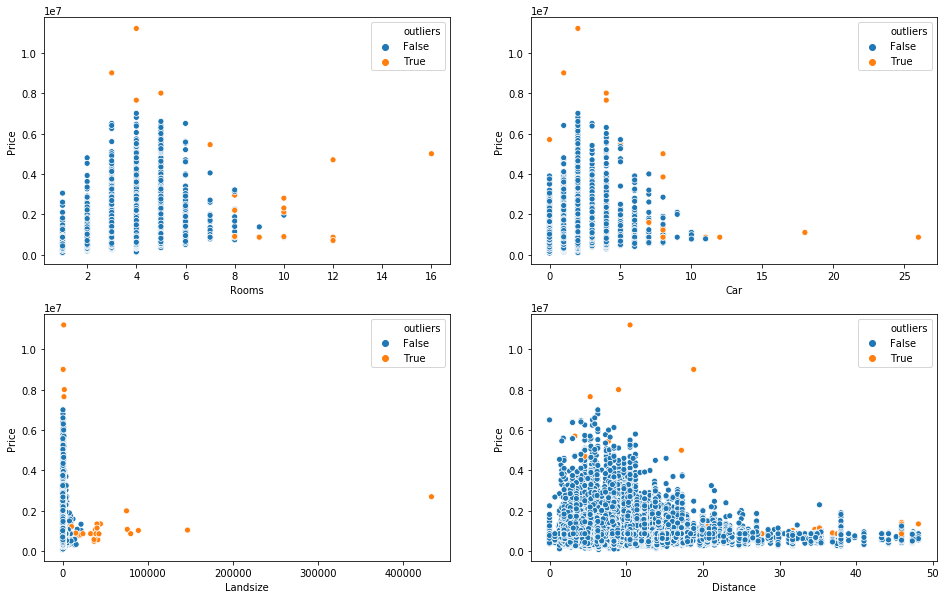

In [24]:
plt.figure(figsize=(16,10))
df_housing_outlier = df_housing
df_housing_outlier['outliers'] = [True if l == -1 else False for l in labels]

ax1=plt.subplot(2, 2, 1)
sns.scatterplot(x="Rooms", y="Price", hue='outliers', data=df_housing_outlier,ax=ax1)
ax2=plt.subplot(2, 2, 2)
sns.scatterplot(x="Car", y="Price", hue='outliers', data=df_housing_outlier,ax=ax2)
ax3=plt.subplot(2, 2, 3)
sns.scatterplot(x="Landsize", y="Price", hue='outliers', data=df_housing_outlier,ax=ax3)
ax4=plt.subplot(2, 2, 4)
sns.scatterplot(x="Distance", y="Price", hue='outliers', data=df_housing_outlier,ax=ax4)